In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, BatchNormalization
import scipy.io
import time
import matplotlib.pyplot as plt

In [ ]:
N = 2
M = 2**(N*4)
se = np.log2(M)/N
Q = 128
nBits = int(np.log2(M))

print("Subblock length: " + str(N))
print("Number of messages: " + str(M))
print("Spectral efficiency: " + str(se) + " (bits/s/Hz)")

Subblock length: 2
Number of messages: 256
Spectral efficiency: 4.0 (bits/s/Hz)


In [ ]:
def real_to_complex(x):
    real = x[:,0:int(int(x.shape[1])/2)]
    imag = x[:,int(int(x.shape[1])/2):int(x.shape[1])]
    return tf.dtypes.complex(real,imag)

def channel(x):
    SNRdB = 7
    N0 = 1/(10**(SNRdB/10))
    N0 = K.constant(N0, dtype='float32')

    nR = K.random_normal(K.shape(x), mean=0, stddev=K.sqrt(N0/2))
    nI = K.random_normal(K.shape(x), mean=0, stddev=K.sqrt(N0/2))
    n = tf.dtypes.complex(nR,nI)

    y = x + n

    yR = tf.math.real(y)
    yI = tf.math.imag(y)

    return tf.concat([yR,yI],-1)

In [ ]:
# ------------------------------------------ Encoder ---------------------------------------------
input_signal = keras.Input(shape=(M,))
encoded1 = layers.Dense(units=Q, activation='relu',name='ReLu_Layer1',kernel_initializer='normal')(input_signal)
encoded2 = layers.Dense(units=2*N, activation='linear',name='Linear_Layer',kernel_initializer='normal')(encoded1)
# encoded3 = Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))(encoded2)
encoded3 = Lambda(lambda x: np.sqrt(N)*K.l2_normalize(x, axis=1))(encoded2)
Lambda1 = Lambda(real_to_complex)(encoded3)
# ---------------------------------- Wireless Channel (y=Hx+n) -----------------------------------
Lambda2 = Lambda(channel)(Lambda1)
# ------------------------------------------ Decoder ---------------------------------------------
decoded1 = layers.Dense(Q, activation='relu',name='ReLu_Layer2',kernel_initializer='normal')(Lambda2)
decoded2 = layers.Dense(M, activation='softmax',name='softmax_Layer',kernel_initializer='normal')(decoded1)

In [ ]:
autoencoder = keras.Model(input_signal, decoded2)
opt = keras.optimizers.Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss='categorical_crossentropy')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 ReLu_Layer1 (Dense)         (None, 128)               32896     
                                                                 
 Linear_Layer (Dense)        (None, 4)                 516       
                                                                 
 lambda_3 (Lambda)           (None, 4)                 0         
                                                                 
 lambda_4 (Lambda)           (None, 2)                 0         
                                                                 
 lambda_5 (Lambda)           (None, 4)                 0         
                                                                 
 ReLu_Layer2 (Dense)         (None, 128)               640 

In [ ]:
train_size = 100000
x_train = np.zeros((train_size,M))
J = np.random.choice(M, train_size)
for i, j in enumerate(J):
    x_train[i, j] = 1

In [ ]:
test_size = 10000
x_test = np.zeros((test_size,M))
J = np.random.choice(M, test_size)
for i, j in enumerate(J):
    x_test[i, j] = 1

In [ ]:
# Training autoencoder
t1 = time.time()
history = autoencoder.fit(x_train, x_train,
                epochs = 1000,
                batch_size = 512,
                shuffle = True,
                validation_data = (x_test, x_test))
print("--- %s saniye ---" % (time.time() - t1))

Epoch 1/1000
196/196 [==============================] - 3s 12ms/step - loss: 5.4768 - val_loss: 5.4014
Epoch 2/1000
196/196 [==============================] - 2s 10ms/step - loss: 5.2936 - val_loss: 5.1663
Epoch 3/1000
196/196 [==============================] - 3s 14ms/step - loss: 5.0156 - val_loss: 4.8549
Epoch 4/1000
196/196 [==============================] - 3s 15ms/step - loss: 4.6881 - val_loss: 4.5249
Epoch 5/1000
196/196 [==============================] - 3s 13ms/step - loss: 4.3663 - val_loss: 4.2140
Epoch 6/1000
196/196 [==============================] - 2s 10ms/step - loss: 4.0725 - val_loss: 3.9380
Epoch 7/1000
196/196 [==============================] - 2s 10ms/step - loss: 3.8207 - val_loss: 3.7099
Epoch 8/1000
196/196 [==============================] - 2s 10ms/step - loss: 3.6044 - val_loss: 3.5062
Epoch 9/1000
196/196 [==============================] - 2s 10ms/step - loss: 3.4246 - val_loss: 3.3437
Epoch 10/1000
196/196 [==============================] - 3s 13ms/step - l

dict_keys(['loss', 'val_loss'])


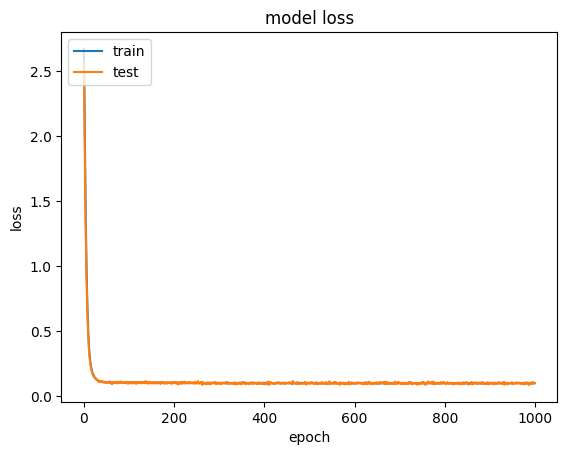

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Encoder
encoder = keras.Model(input_signal, Lambda1)


# Decoder
encoded_input = Input(shape=(2*N,))
deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = keras.Model(encoded_input, deco)

# encoder.save("my_encoder.h5")
# decoder.save("my_decoder.h5")

In [ ]:
# v = np.zeros((M,nBits))
# for ii in range(M):
#     a = [int(x) for x in bin(ii)[2:]]
#     b = [int(x) for x in list('{0:0b}'.format(ii))]
#     v[ii,nBits-len(b):nBits] = b

v = np.ones(M)
v = np.diag(v)
SignalSet = encoder.predict(v)
print(np.mean(np.abs(SignalSet)**2))

1/1 [==============================] - 0s 124ms/step
0.9999999


In [ ]:
aa = 0
ED = np.zeros(M*(M-1))
for xVal in range(M):
    for xxVal in range(M):
        if xVal != xxVal:
            X = SignalSet[xVal,:]
            XX = SignalSet[xxVal,:]
            ED[aa] = np.linalg.norm(X-XX)**2
            aa += 1

print(np.min(ED))
print(np.mean(ED))

2.2070700370285437
4.266366776672516


In [ ]:
scipy.io.savemat('SS_1_bps_N4_Q32_6.3898.mat', mdict={'SignalSet': SignalSet, 'Loss':history.history['loss'], 'ValLoss':history.history['val_loss']})
decoder.compile(optimizer='adam', loss='categorical_crossentropy')
encoder.save("my_encoder.h5")
decoder.save("my_decoder.h5")